# MAGIC

In this notebook, we use molecular cross-validation to find the optimal set of hyperparameters for the MAGIC algorithm on a dataset from

*David van Dijk, et al. Recovering Gene Interactions from Single-Cell Data Using Data Diffusion. 2018. Cell.*

We find that the optimal parameters produce a much less smooth picture of the relationship between three genes, *CDH1, VIM, ZEB1* than the default parameters do, indicating the importance of calibrating denoising methods.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import scanpy as sc

import magic

In [4]:
data = sc.read('../data/magic/HMLE_TGFb_day_8_10.csv.gz')

sc.pp.filter_cells(data, min_counts=1000)
sc.pp.filter_genes(data, min_cells=10)
data.X = data.X.astype(np.int)

In [5]:
x1 = np.random.binomial(data.X, 0.5)
x2 = data.X - x1

n_counts = np.median(data.X.sum(axis=1)) / 2

x1_norm = x1 / x1.sum(axis=1, keepdims=True) * n_counts
x2_norm = x2 / x2.sum(axis=1, keepdims=True) * n_counts

In [6]:
data1 = pd.DataFrame(
    data=x1_norm, index=data.obs_names, columns=data.var_names
)
data2 = pd.DataFrame(
    data=x2_norm, index=data.obs_names, columns=data.var_names
)

In [7]:
# MAGIC with defult parameters
# (the warning is a known bug and can be ignored, see
# https://github.com/KrishnaswamyLab/MAGIC/issues/152)
genes = ['VIM', 'CDH1', 'ZEB1']

default_denoised = magic.MAGIC().fit_transform(data1, genes=genes)
default_denoised = np.maximum(default_denoised, 0)

Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 18.64 seconds.
    Calculating KNN search...
    Calculated KNN search in 9.20 seconds.
    Calculating affinities...
    Calculated affinities in 3.10 seconds.
  Calculated graph and diffusion operator in 32.03 seconds.
  Calculating imputation...
    Automatically selected t = 7
  Calculated imputation in 1.49 seconds.
Calculated MAGIC in 36.41 seconds.


We tune three hyperparameters of the MAGIC method:
    
1. The number of principal components used
2. The number of neighbors to use in constructing the graph
3. The diffusion time

Default values:
    * n_pca=100
    * knn=10
    * t='auto' (set to 7 for our dataset)

Optimal values:
    * n_pca=20
    * knn=4
    * t=1
    
Raw equivalent values:
    * n_pca = max (~5000)
    * knn=0
    * t=0

In [36]:
k_range = np.arange(2, 12, 2, dtype=np.int)
pc_range = np.arange(10, 30, 5, dtype=np.int)
t_range = np.arange(1, 6, dtype=np.int)

In [20]:
results = []

for n_pcs in pc_range:
    magic_op = magic.MAGIC(n_pca=n_pcs)
    for k in k_range:
        for t in t_range:
            magic_op.set_params(knn=k, t=t)
            denoised = magic_op.fit_transform(data1, genes=genes)
            denoised = np.maximum(denoised, 0)
            results.append((t, n_pcs, k, denoised))

      Calculating MAGIC...
      Running MAGIC on 7523 cells and 18259 genes.
      Calculating graph and diffusion operator...
      Calculating PCA...
    Calculated PCA in 10.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.13 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 12.12 seconds.
  Calculating imputation...
Calculated MAGIC in 13.53 seconds.
Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
Calculated MAGIC in 1.61 seconds.
Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
Calculated MAGIC in 1.64 seconds.
Calculating MAGIC...
  Running MAGIC on 7523 cells and 18259 genes.
  Using precomputed graph and diffusion operator...
  Calculating imputation...
Calculated MAGIC in 1.89 seco

Visualize the results of the hyperparameter sweep.

In [37]:
rows = []

for t, n_pcs, k, denoised in results:
    losses = ((denoised - data2[genes])**2).mean()
    d = {"t": t, "n_pcs": n_pcs, "k": k, "loss": losses.sum()}
    for gene in genes:
        d[gene] = losses[gene]
    rows.append(d)

df = pd.DataFrame(rows)

df.to_csv('../results/magic_parameter_sweep.csv')

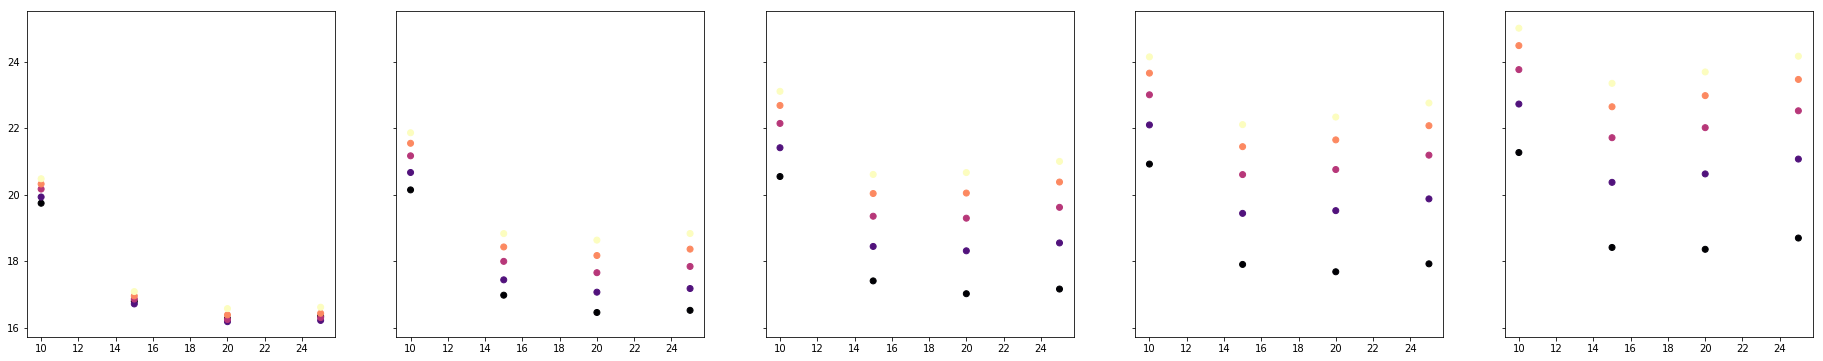

In [38]:
fig,ax = plt.subplots(1, len(t_range), sharey=True, figsize=(32, 6))
for i,t in enumerate(t_range):
    ix = df["t"] == t
    ax[i].scatter(df[ix]["n_pcs"], df[ix]["loss"], c=df[ix]["k"], cmap="magma")

plt.show()

The best-performing hyperparameters for MAGIC:

In [46]:
opt_idx = df['loss'].idxmin()

opt_denoised = results[opt_idx][-1]
opt_denoised = np.maximum(opt_denoised, 0)

df.loc[opt_idx][['k', 'n_pcs','t','loss']]

k         4.000000
n_pcs    20.000000
t         1.000000
loss     16.176898
Name: 55, dtype: float64

Visualize the curves passing through the best set of parameters.

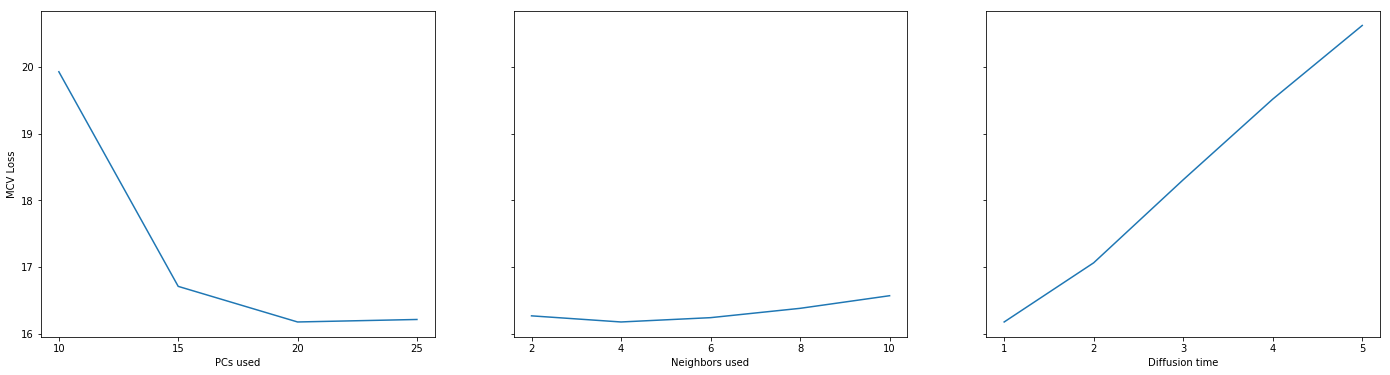

In [43]:
#df = pd.read_csv('../results/magic_parameter_sweep.csv')
is_opt_n_pcs = (df.n_pcs == df.loc[opt_idx].n_pcs)
is_opt_k = (df.k == df.loc[opt_idx].k)
is_opt_t = (df.t == df.loc[opt_idx].t)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(24, 6))
ax[0].plot(df.loc[is_opt_k & is_opt_t].n_pcs, df.loc[is_opt_k & is_opt_t].loss)
ax[0].set_ylabel('MCV Loss')
ax[0].set_xlabel('PCs used')
ax[0].set_xticks(pc_range)

ax[1].plot(df.loc[is_opt_n_pcs & is_opt_t].k, df.loc[is_opt_n_pcs & is_opt_t].loss)
ax[1].set_xlabel('Neighbors used')
ax[1].set_xticks(k_range)

ax[2].plot(df.loc[is_opt_k & is_opt_n_pcs].t, df.loc[is_opt_k & is_opt_n_pcs].loss)
ax[2].set_xlabel('Diffusion time')
ax[2].set_xticks(t_range)

plt.savefig('../figures/Figure_3_sweep.svg')

## Plot

In [44]:
def plot_dfs(dfs, titles, xticks, yticks, cbar_ticks):
    fig,ax = plt.subplots(
        len(dfs), 2,
        sharex=False,
        sharey=False,
        figsize=(8, 18),
        gridspec_kw={'width_ratios': [10, 1]},
    )

    cmap = plt.get_cmap('magma')
    for i,df in enumerate(dfs):
        norm = plt.Normalize(df[genes[2]].min(), df[genes[2]].max())

        ax[i,0].scatter(
            df[genes[0]], df[genes[1]], 
            c = df[genes[2]],
            cmap=cmap, 
            norm=norm,
            alpha=0.5
        )

        ax[i,0].set_xlabel(genes[0])
        ax[i,0].set_ylabel(genes[1])

        ax[i,0].set_xticks(xticks[i])
        ax[i,0].set_yticks(yticks[i])

        x_marg = np.ptp(xticks[i]) / 20
        y_marg = np.ptp(yticks[i]) / 20

        ax[i,0].set_xlim(-x_marg, None)
        ax[i,0].set_ylim(-y_marg, None)
        ax[i,0].margins(0.05)
        ax[i,0].autoscale_view()
        ax[i,0].set_title(titles[i])

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        plt.colorbar(
            sm,
            cax=ax[i,1], 
            label=genes[2],
            ticks=cbar_ticks[i]
        )

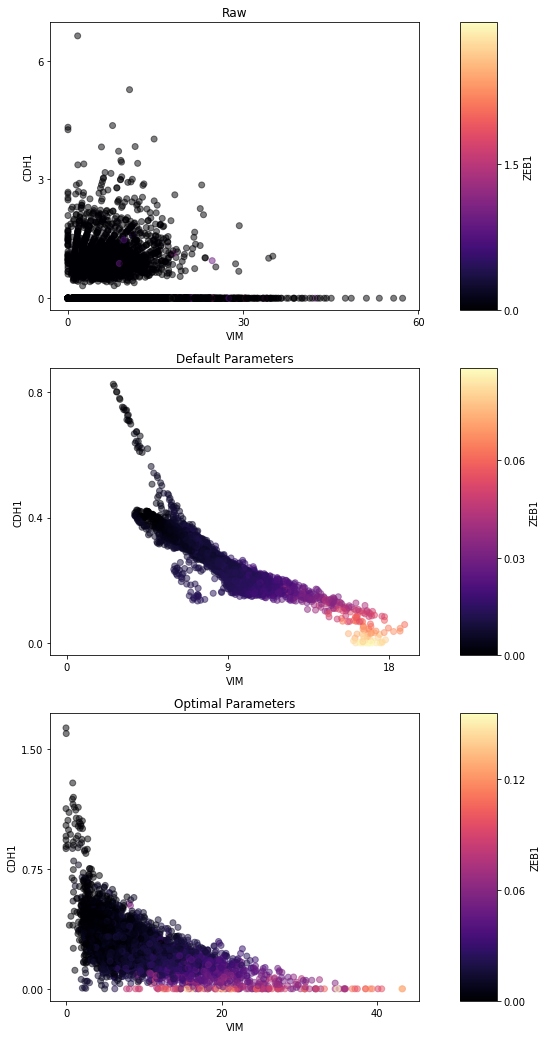

In [45]:
genes_idx = np.array([data.var_names.get_loc(g) for g in genes])
raw = pd.DataFrame(data = x1_norm[:, genes_idx], columns=genes)

plot_dfs(
    [raw, default_denoised, opt_denoised],
    ["Raw", "Default Parameters", "Optimal Parameters"],
    [[0, 30, 60], [0, 9, 18], [0, 20, 40]],
    [[0, 3, 6], [0, 0.4, 0.8], [0, 0.75, 1.5]],
    [[0, 1.5, 3], [0, 0.03, 0.06], [0, 0.06, 0.12]],
)
plt.savefig('../figures/Figure_3_raw.svg')